# GOOGLE stock prediction using recurrent neural network

In [170]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math, time
import itertools
from sklearn import preprocessing
from datetime import datetime
from operator import itemgetter
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import googlefinance.client
import requests

DATE,CLOSE,HIGH,LOW,OPEN,VOLUME

In [195]:
from googlefinance.client import get_price_data, get_prices_data, get_prices_time_data

# Dow Jones
param = {
    'q': "GOOGL", # Stock symbol (ex: "AAPL")
    'i': "86400", # Interval size in seconds ("86400" = 1 day intervals)
    'p': "10Y" # Period (Ex: "1Y" = 1 year)
}
# get price data (return pandas dataframe)
r = requests.get("https://finance.google.com/finance/getprices", params=param)
lines = r.text.splitlines()
data = []
index = []
basetime = 0
for price in lines:
    cols = price.split(",")
    if cols[0][0] == 'a':
        basetime = int(cols[0][1:])
        index.append(datetime.fromtimestamp(basetime).date())
        data.append([float(cols[4]), float(cols[2]), float(cols[3]), int(cols[5]), float(cols[1])])
    elif cols[0][0].isdigit():
        date = basetime + (int(cols[0])*int(param['i']))
        index.append(datetime.fromtimestamp(date).date())
        data.append([float(cols[4]), float(cols[2]), float(cols[3]), int(cols[5]), float(cols[1])])
df = pd.DataFrame(data, index = index, columns = ['Open', 'High', 'Low', 'Volume', 'Close'])

In [196]:
df.head()

,Open,High,Low,Volume,Close
2007-12-10,358.35,362.760,357.360,3858284,359.570
2007-12-11,360.33,360.855,349.739,6142422,349.952
2007-12-12,357.36,357.520,344.590,6166134,350.020
2007-12-13,348.50,349.160,340.950,5182202,347.370
2007-12-14,344.10,350.200,343.970,3673495,345.320


In [197]:
df[['Open', 'High', 'Low', 'Close']] /= 1000
df['Volume'] /= 10000000
df.shape

(2517, 5)

In [200]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() #pd.DataFrame(stock)
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [201]:
batch_size = 5
X_train, y_train, X_test, y_test = load_data(df, batch_size)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (2260, 5, 5)
y_train (2260,)
X_test (251, 5, 5)
y_test (251,)


In [202]:
def build_model2(layers):
        d = 0.2
        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))
        model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        model.add(Dropout(d))
        model.add(Dense(16,kernel_initializer='uniform',activation='relu'))        
        model.add(Dense(1,kernel_initializer='uniform',activation='relu'))
        model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
        return model

In [203]:
model = build_model2([5,window,1])

In [204]:
model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=500,
    validation_split=0.1,
    verbose=0)

In [205]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.00 MSE (0.01 RMSE)
Test Score: 0.00 MSE (0.02 RMSE)


In [206]:
# print(X_test[-1])
diff=[]
ratio=[]
p = model.predict(X_test)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    #print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))

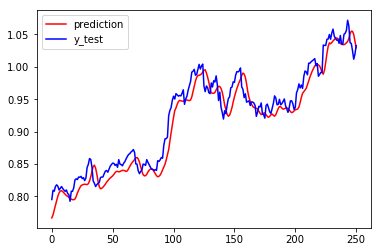

In [207]:
import matplotlib.pyplot as plt2

plt2.plot(p,color='red', label='prediction')
plt2.plot(y_test,color='blue', label='y_test')
plt2.legend(loc='upper left')
plt2.show()